# 데모

## 라이브러리 import 및 설정

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import optuna.integration.lightgbm as lgb
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [12]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [27]:
data_dir = Path('./input')
feature_dir = Path('./input')
sub_dir = Path('./input')
val_dir = Path('./input')
tst_dir = Path('./input')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [28]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [29]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 38)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,tmp1,tmp2,z_i,z_r,z_g,z_u,i_r,i_g,i_u,r_g,r_u,g_u,d_dered_ug,d_dered_gr,d_dered_iz,d_dered_ri,d_dered_gi,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_rg,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,1.1898,0.0,-2.9272,-1.3371,-0.7328,-2.0699,-3.3972,-6.3243,-1.3371,-2.6643,-5.5915,-1.3273,-4.2545,-2.9272,2.8665,1.3027,0.7232,1.3230,2.6257,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-1.3027,-4.1691,-2.8665,1.0000
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1.2533,1.0,-0.9902,-0.1840,-0.0995,-0.2835,-0.8930,-1.8832,-0.1840,-0.7935,-1.7837,-0.6096,-1.5997,-0.9902,0.9619,0.5931,0.1016,0.1751,0.7683,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-0.5931,-1.5550,-0.9619,1.0000
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,1.0225,0.0,-0.9610,-0.1428,-0.0435,-0.1863,-0.4754,-1.4364,-0.1428,-0.4319,-1.3928,-0.2891,-1.2501,-0.9610,0.9211,0.2466,0.0257,0.1183,0.3649,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-0.2466,-1.1676,-0.9211,1.0000
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,1.2054,0.0,-4.4719,-0.3262,-0.2603,-0.5865,-1.5541,-6.0260,-0.3262,-1.2938,-5.7657,-0.9676,-5.4395,-4.4719,4.3590,0.9074,0.2395,0.2926,1.2000,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-0.9074,-5.2664,-4.3590,0.7500
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,1.1939,0.0,-3.7543,-0.7182,-0.3415,-1.0597,-2.7165,-6.4708,-0.7182,-2.3750,-6.1293,-1.6568,-5.4111,-3.7543,3.3376,1.5709,0.3144,0.6727,2.2436,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-1.5709,-4.9084,-3.3376,0.9231


In [30]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 37) (80000, 37)


## Hyperparameter Tuning

In [31]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=0)

In [37]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "n_estimators": 3000,
    "subsample_freq": 1,
    "lambda_l1": 0.9,
    "lambda_l2": 0.9,
    "random_state": seed,
    "n_jobs": -1,
    "force_col_wise" : True
}

In [ ]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], 
                  verbose_eval=100, early_stopping_rounds=10)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), 
                       axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

[I 2020-10-08 14:39:38,916] A new study created in memory with name: no-name-6d4cbf97-7cf3-453d-b5dc-42a0c77a6316



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.148314	valid_1's multi_logloss: 0.159746
[200]	training's multi_logloss: 0.136528	valid_1's multi_logloss: 0.156626
[300]	training's multi_logloss: 0.128023	valid_1's multi_logloss: 0.155847
Early stopping, best iteration is:
[307]	training's multi_logloss: 0.127476	valid_1's multi_logloss: 0.155809





feature_fraction, val_score: 0.155809:   0%|                                                     | 0/7 [00:12<?, ?it/s]


feature_fraction, val_score: 0.155809:  14%|######4                                      | 1/7 [00:12<01:17, 12.91s/it][I 2020-10-08 14:39:51,834] Trial 0 finished with value: 0.15580912878368372 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.15580912878368372.



feature_fraction, val_score: 0.155809:  14%|######4                                      | 1/7 [00:12<01:17, 12.91s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.144947	valid_1's multi_logloss: 0.157958
[200]	training's multi_logloss: 0.133451	valid_1's multi_logloss: 0.155827
Early stopping, best iteration is:
[269]	training's multi_logloss: 0.127441	valid_1's multi_logloss: 0.1555





feature_fraction, val_score: 0.155500:  14%|######4                                      | 1/7 [00:27<01:17, 12.91s/it]


feature_fraction, val_score: 0.155500:  29%|############8                                | 2/7 [00:27<01:07, 13.46s/it][I 2020-10-08 14:40:06,570] Trial 1 finished with value: 0.15549972550728436 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.15549972550728436.



feature_fraction, val_score: 0.155500:  29%|############8                                | 2/7 [00:27<01:07, 13.46s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.145666	valid_1's multi_logloss: 0.157877
[200]	training's multi_logloss: 0.134275	valid_1's multi_logloss: 0.155896
Early stopping, best iteration is:
[252]	training's multi_logloss: 0.129715	valid_1's multi_logloss: 0.155571





feature_fraction, val_score: 0.155500:  29%|############8                                | 2/7 [00:41<01:07, 13.46s/it]


feature_fraction, val_score: 0.155500:  43%|###################2                         | 3/7 [00:41<00:53, 13.46s/it][I 2020-10-08 14:40:20,044] Trial 2 finished with value: 0.15557089792246645 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.15549972550728436.



feature_fraction, val_score: 0.155500:  43%|###################2                         | 3/7 [00:41<00:53, 13.46s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.146004	valid_1's multi_logloss: 0.158355
[200]	training's multi_logloss: 0.13475	valid_1's multi_logloss: 0.156278
Early stopping, best iteration is:
[269]	training's multi_logloss: 0.128719	valid_1's multi_logloss: 0.155807





feature_fraction, val_score: 0.155500:  43%|###################2                         | 3/7 [00:55<00:53, 13.46s/it]


feature_fraction, val_score: 0.155500:  57%|#########################7                   | 4/7 [00:55<00:41, 13.72s/it][I 2020-10-08 14:40:34,363] Trial 3 finished with value: 0.15580682373844262 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.15549972550728436.



feature_fraction, val_score: 0.155500:  57%|#########################7                   | 4/7 [00:55<00:41, 13.72s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.145242	valid_1's multi_logloss: 0.157904
[200]	training's multi_logloss: 0.133886	valid_1's multi_logloss: 0.155894
Early stopping, best iteration is:
[253]	training's multi_logloss: 0.12909	valid_1's multi_logloss: 0.155583





feature_fraction, val_score: 0.155500:  57%|#########################7                   | 4/7 [01:09<00:41, 13.72s/it]


feature_fraction, val_score: 0.155500:  71%|################################1            | 5/7 [01:09<00:27, 13.97s/it][I 2020-10-08 14:40:48,915] Trial 4 finished with value: 0.15558278445431287 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.15549972550728436.



feature_fraction, val_score: 0.155500:  71%|################################1            | 5/7 [01:09<00:27, 13.97s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.14661	valid_1's multi_logloss: 0.158456
[200]	training's multi_logloss: 0.135106	valid_1's multi_logloss: 0.156148
[300]	training's multi_logloss: 0.126821	valid_1's multi_logloss: 0.155607
Early stopping, best iteration is:
[313]	training's multi_logloss: 0.125869	valid_1's multi_logloss: 0.155563





feature_fraction, val_score: 0.155500:  71%|################################1            | 5/7 [01:26<00:27, 13.97s/it]


feature_fraction, val_score: 0.155500:  86%|######################################5      | 6/7 [01:26<00:14, 14.72s/it][I 2020-10-08 14:41:05,378] Trial 5 finished with value: 0.15556283059071377 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.15549972550728436.



feature_fraction, val_score: 0.155500:  86%|######################################5      | 6/7 [01:26<00:14, 14.72s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.144572	valid_1's multi_logloss: 0.157919
[200]	training's multi_logloss: 0.133039	valid_1's multi_logloss: 0.156028
Early stopping, best iteration is:
[229]	training's multi_logloss: 0.130519	valid_1's multi_logloss: 0.155825





feature_fraction, val_score: 0.155500:  86%|######################################5      | 6/7 [01:42<00:14, 14.72s/it]


feature_fraction, val_score: 0.155500: 100%|#############################################| 7/7 [01:42<00:00, 14.67s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 0.155500:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0904722	valid_1's multi_logloss: 0.155192





num_leaves, val_score: 0.155192:   0%|                                                          | 0/20 [00:14<?, ?it/s]


num_leaves, val_score: 0.155192:   5%|##5                                               | 1/20 [00:14<04:34, 14.46s/it][I 2020-10-08 14:41:36,078] Trial 7 finished with value: 0.1551923736558901 and parameters: {'num_leaves': 231}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:   5%|##5                                               | 1/20 [00:14<04:34, 14.46s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:   5%|##5                                               | 1/20 [00:28<04:34, 14.46s/it]


num_leaves, val_score: 0.155192:  10%|#####                                             | 2/20 [00:28<04:19, 14.42s/it][I 2020-10-08 14:41:50,395] Trial 8 finished with value: 0.15552686278140215 and parameters: {'num_leaves': 80}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  10%|#####                                             | 2/20 [00:28<04:19, 14.42s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:  10%|#####                                             | 2/20 [00:42<04:19, 14.42s/it]


num_leaves, val_score: 0.155192:  15%|#######5                                          | 3/20 [00:42<04:01, 14.21s/it][I 2020-10-08 14:42:04,135] Trial 9 finished with value: 0.15544340048535293 and parameters: {'num_leaves': 78}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  15%|#######5                                          | 3/20 [00:42<04:01, 14.21s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:  15%|#######5                                          | 3/20 [00:54<04:01, 14.21s/it]


num_leaves, val_score: 0.155192:  20%|##########                                        | 4/20 [00:54<03:35, 13.45s/it][I 2020-10-08 14:42:15,800] Trial 10 finished with value: 0.1558778454807793 and parameters: {'num_leaves': 255}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  20%|##########                                        | 4/20 [00:54<03:35, 13.45s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:  20%|##########                                        | 4/20 [01:05<03:35, 13.45s/it]


num_leaves, val_score: 0.155192:  25%|############5                                     | 5/20 [01:05<03:11, 12.78s/it][I 2020-10-08 14:42:27,004] Trial 11 finished with value: 0.15599734078590205 and parameters: {'num_leaves': 208}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  25%|############5                                     | 5/20 [01:05<03:11, 12.78s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.155463	valid_1's multi_logloss: 0.161912
[200]	training's multi_logloss: 0.146956	valid_1's multi_logloss: 0.158233
[300]	training's multi_logloss: 0.141458	valid_1's multi_logloss: 0.156842
Early stopping, best iteration is:
[336]	training's multi_logloss: 0.139736	valid_1's multi_logloss: 0.156615





num_leaves, val_score: 0.155192:  25%|############5                                     | 5/20 [01:24<03:11, 12.78s/it]


num_leaves, val_score: 0.155192:  30%|###############                                   | 6/20 [01:24<03:27, 14.80s/it][I 2020-10-08 14:42:46,532] Trial 12 finished with value: 0.15661465857736592 and parameters: {'num_leaves': 14}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  30%|###############                                   | 6/20 [01:24<03:27, 14.80s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:  30%|###############                                   | 6/20 [01:36<03:27, 14.80s/it]


num_leaves, val_score: 0.155192:  35%|#################5                                | 7/20 [01:36<03:01, 13.98s/it][I 2020-10-08 14:42:58,587] Trial 13 finished with value: 0.15531364713697438 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  35%|#################5                                | 7/20 [01:36<03:01, 13.98s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:  35%|#################5                                | 7/20 [01:50<03:01, 13.98s/it]


num_leaves, val_score: 0.155192:  40%|####################                              | 8/20 [01:50<02:46, 13.87s/it][I 2020-10-08 14:43:12,201] Trial 14 finished with value: 0.15567854004726892 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  40%|####################                              | 8/20 [01:50<02:46, 13.87s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:  40%|####################                              | 8/20 [02:02<02:46, 13.87s/it]


num_leaves, val_score: 0.155192:  45%|######################5                           | 9/20 [02:02<02:26, 13.34s/it][I 2020-10-08 14:43:24,298] Trial 15 finished with value: 0.1556390873089515 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  45%|######################5                           | 9/20 [02:02<02:26, 13.34s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.155192:  45%|######################5                           | 9/20 [02:14<02:26, 13.34s/it]


num_leaves, val_score: 0.155192:  50%|########################5                        | 10/20 [02:14<02:09, 12.99s/it][I 2020-10-08 14:43:36,473] Trial 16 finished with value: 0.15596558679372144 and parameters: {'num_leaves': 254}. Best is trial 7 with value: 0.1551923736558901.



num_leaves, val_score: 0.155192:  50%|########################5                        | 10/20 [02:14<02:09, 12.99s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  50%|########################5                        | 10/20 [02:26<02:09, 12.99s/it]


num_leaves, val_score: 0.154916:  55%|##########################9                      | 11/20 [02:26<01:54, 12.68s/it][I 2020-10-08 14:43:48,444] Trial 17 finished with value: 0.15491626272411493 and parameters: {'num_leaves': 186}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  55%|##########################9                      | 11/20 [02:26<01:54, 12.68s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  55%|##########################9                      | 11/20 [02:39<01:54, 12.68s/it]


num_leaves, val_score: 0.154916:  60%|#############################4                   | 12/20 [02:39<01:42, 12.76s/it][I 2020-10-08 14:44:01,386] Trial 18 finished with value: 0.15555912250340884 and parameters: {'num_leaves': 206}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  60%|#############################4                   | 12/20 [02:39<01:42, 12.76s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  60%|#############################4                   | 12/20 [02:52<01:42, 12.76s/it]


num_leaves, val_score: 0.154916:  65%|###############################8                 | 13/20 [02:52<01:28, 12.64s/it][I 2020-10-08 14:44:13,738] Trial 19 finished with value: 0.15521265558579672 and parameters: {'num_leaves': 211}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  65%|###############################8                 | 13/20 [02:52<01:28, 12.64s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  65%|###############################8                 | 13/20 [03:03<01:28, 12.64s/it]


num_leaves, val_score: 0.154916:  70%|##################################3              | 14/20 [03:03<01:13, 12.30s/it][I 2020-10-08 14:44:25,248] Trial 20 finished with value: 0.15545819992054344 and parameters: {'num_leaves': 177}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  70%|##################################3              | 14/20 [03:03<01:13, 12.30s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  70%|##################################3              | 14/20 [03:15<01:13, 12.30s/it]


num_leaves, val_score: 0.154916:  75%|####################################7            | 15/20 [03:15<01:01, 12.30s/it][I 2020-10-08 14:44:37,557] Trial 21 finished with value: 0.15593048765813544 and parameters: {'num_leaves': 218}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  75%|####################################7            | 15/20 [03:15<01:01, 12.30s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0904722	valid_1's multi_logloss: 0.155192





num_leaves, val_score: 0.154916:  75%|####################################7            | 15/20 [03:30<01:01, 12.30s/it]


num_leaves, val_score: 0.154916:  80%|#######################################2         | 16/20 [03:30<00:51, 12.88s/it][I 2020-10-08 14:44:51,787] Trial 22 finished with value: 0.1551923736558901 and parameters: {'num_leaves': 231}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  80%|#######################################2         | 16/20 [03:30<00:51, 12.88s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  80%|#######################################2         | 16/20 [03:41<00:51, 12.88s/it]


num_leaves, val_score: 0.154916:  85%|#########################################6       | 17/20 [03:41<00:37, 12.40s/it][I 2020-10-08 14:45:03,072] Trial 23 finished with value: 0.1557515817364744 and parameters: {'num_leaves': 253}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  85%|#########################################6       | 17/20 [03:41<00:37, 12.40s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  85%|#########################################6       | 17/20 [03:53<00:37, 12.40s/it]


num_leaves, val_score: 0.154916:  90%|############################################1    | 18/20 [03:53<00:24, 12.40s/it][I 2020-10-08 14:45:15,467] Trial 24 finished with value: 0.15563211676466726 and parameters: {'num_leaves': 235}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  90%|############################################1    | 18/20 [03:53<00:24, 12.40s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  90%|############################################1    | 18/20 [04:07<00:24, 12.40s/it]


num_leaves, val_score: 0.154916:  95%|##############################################5  | 19/20 [04:07<00:12, 12.77s/it][I 2020-10-08 14:45:29,089] Trial 25 finished with value: 0.15528601010874368 and parameters: {'num_leaves': 174}. Best is trial 17 with value: 0.15491626272411493.



num_leaves, val_score: 0.154916:  95%|##############################################5  | 19/20 [04:07<00:12, 12.77s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




num_leaves, val_score: 0.154916:  95%|##############################################5  | 19/20 [04:20<00:12, 12.77s/it]


num_leaves, val_score: 0.154916: 100%|#################################################| 20/20 [04:20<00:00, 13.04s/it]



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


bagging, val_score: 0.154916:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:   0%|                                                             | 0/10 [00:09<?, ?it/s]


bagging, val_score: 0.154916:  10%|#####3                                               | 1/10 [00:09<01:27,  9.70s/it][I 2020-10-08 14:45:52,060] Trial 27 finished with value: 0.15717028860387108 and parameters: {'bagging_fraction': 0.5374593499240748, 'bagging_freq': 4}. Best is trial 27 with value: 0.15717028860387108.



bagging, val_score: 0.154916:  10%|#####3                                               | 1/10 [00:09<01:27,  9.70s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  10%|#####3                                               | 1/10 [00:21<01:27,  9.70s/it]


bagging, val_score: 0.154916:  20%|##########6                                          | 2/10 [00:21<01:23, 10.44s/it][I 2020-10-08 14:46:04,217] Trial 28 finished with value: 0.15538739220354864 and parameters: {'bagging_fraction': 0.9693525528465246, 'bagging_freq': 7}. Best is trial 28 with value: 0.15538739220354864.



bagging, val_score: 0.154916:  20%|##########6                                          | 2/10 [00:21<01:23, 10.44s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  20%|##########6                                          | 2/10 [00:34<01:23, 10.44s/it]


bagging, val_score: 0.154916:  30%|###############9                                     | 3/10 [00:34<01:18, 11.22s/it][I 2020-10-08 14:46:17,260] Trial 29 finished with value: 0.15514994349655653 and parameters: {'bagging_fraction': 0.9895771692894553, 'bagging_freq': 1}. Best is trial 29 with value: 0.15514994349655653.



bagging, val_score: 0.154916:  30%|###############9                                     | 3/10 [00:34<01:18, 11.22s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  30%|###############9                                     | 3/10 [00:46<01:18, 11.22s/it]


bagging, val_score: 0.154916:  40%|#####################2                               | 4/10 [00:46<01:07, 11.27s/it][I 2020-10-08 14:46:28,647] Trial 30 finished with value: 0.15520084983106897 and parameters: {'bagging_fraction': 0.9733242285330279, 'bagging_freq': 1}. Best is trial 29 with value: 0.15514994349655653.



bagging, val_score: 0.154916:  40%|#####################2                               | 4/10 [00:46<01:07, 11.27s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  40%|#####################2                               | 4/10 [01:00<01:07, 11.27s/it]


bagging, val_score: 0.154916:  50%|##########################5                          | 5/10 [01:00<01:00, 12.04s/it][I 2020-10-08 14:46:42,495] Trial 31 finished with value: 0.15547018278298813 and parameters: {'bagging_fraction': 0.7665099178437781, 'bagging_freq': 1}. Best is trial 29 with value: 0.15514994349655653.



bagging, val_score: 0.154916:  50%|##########################5                          | 5/10 [01:00<01:00, 12.04s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  50%|##########################5                          | 5/10 [01:12<01:00, 12.04s/it]


bagging, val_score: 0.154916:  60%|###############################8                     | 6/10 [01:12<00:48, 12.01s/it][I 2020-10-08 14:46:54,419] Trial 32 finished with value: 0.15607345211274695 and parameters: {'bagging_fraction': 0.7741660055433005, 'bagging_freq': 3}. Best is trial 29 with value: 0.15514994349655653.



bagging, val_score: 0.154916:  60%|###############################8                     | 6/10 [01:12<00:48, 12.01s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  60%|###############################8                     | 6/10 [01:21<00:48, 12.01s/it]


bagging, val_score: 0.154916:  70%|#####################################                | 7/10 [01:21<00:33, 11.26s/it][I 2020-10-08 14:47:03,939] Trial 33 finished with value: 0.15867821952598707 and parameters: {'bagging_fraction': 0.4131264451222843, 'bagging_freq': 4}. Best is trial 29 with value: 0.15514994349655653.



bagging, val_score: 0.154916:  70%|#####################################                | 7/10 [01:21<00:33, 11.26s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  70%|#####################################                | 7/10 [01:33<00:33, 11.26s/it]


bagging, val_score: 0.154916:  80%|##########################################4          | 8/10 [01:33<00:22, 11.37s/it][I 2020-10-08 14:47:15,580] Trial 34 finished with value: 0.15584138712572868 and parameters: {'bagging_fraction': 0.8865716668012402, 'bagging_freq': 7}. Best is trial 29 with value: 0.15514994349655653.



bagging, val_score: 0.154916:  80%|##########################################4          | 8/10 [01:33<00:22, 11.37s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit




bagging, val_score: 0.154916:  80%|##########################################4          | 8/10 [01:46<00:22, 11.37s/it]


bagging, val_score: 0.154916:  90%|###############################################7     | 9/10 [01:46<00:12, 12.08s/it][I 2020-10-08 14:47:29,298] Trial 35 finished with value: 0.156190927481934 and parameters: {'bagging_fraction': 0.5977966137959927, 'bagging_freq': 2}. Best is trial 29 with value: 0.15514994349655653.



bagging, val_score: 0.154916:  90%|###############################################7     | 9/10 [01:46<00:12, 12.08s/it]

[LightGBM] [Info] Total Bins 9058
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 37
[LightGBM] [Info] Start training from score -0.980923
[LightGBM] [Info] Start training from score -2.014796
[LightGBM] [Info] Start training from score -0.709912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Stratified K-Fold Cross Validation

In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [12]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[LightGBM] [Warning] feature_fraction is set=0.6839999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6839999999999999
[LightGBM] [Warning] lambda_l1 is set=4.110346747914383e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.110346747914383e-08
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=7.908355210421185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.908355210421185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 0.846918
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.743356
[3]	valid_0's multi_logloss: 0.6547
[4]	valid_0's multi_logloss: 0.588042
[5]	valid_0's multi_logloss: 0.529145
[6]	valid_0's multi_logloss: 0.479957
[7]	valid_0's multi_logloss: 0.437376


[127]	valid_0's multi_logloss: 0.156004
[128]	valid_0's multi_logloss: 0.156006
[129]	valid_0's multi_logloss: 0.155997
[130]	valid_0's multi_logloss: 0.156001
[131]	valid_0's multi_logloss: 0.155981
[132]	valid_0's multi_logloss: 0.155971
[133]	valid_0's multi_logloss: 0.15596
[134]	valid_0's multi_logloss: 0.155945
[135]	valid_0's multi_logloss: 0.155963
[136]	valid_0's multi_logloss: 0.155953
[137]	valid_0's multi_logloss: 0.155951
[138]	valid_0's multi_logloss: 0.155937
[139]	valid_0's multi_logloss: 0.155914
[140]	valid_0's multi_logloss: 0.155915
[141]	valid_0's multi_logloss: 0.155899
[142]	valid_0's multi_logloss: 0.155909
[143]	valid_0's multi_logloss: 0.155898
[144]	valid_0's multi_logloss: 0.155876
[145]	valid_0's multi_logloss: 0.155874
[146]	valid_0's multi_logloss: 0.155846
[147]	valid_0's multi_logloss: 0.155824
[148]	valid_0's multi_logloss: 0.155809
[149]	valid_0's multi_logloss: 0.155782
[150]	valid_0's multi_logloss: 0.155779
[151]	valid_0's multi_logloss: 0.155786
[

[131]	valid_0's multi_logloss: 0.157807
[132]	valid_0's multi_logloss: 0.157787
[133]	valid_0's multi_logloss: 0.157778
[134]	valid_0's multi_logloss: 0.157777
[135]	valid_0's multi_logloss: 0.157743
[136]	valid_0's multi_logloss: 0.157718
[137]	valid_0's multi_logloss: 0.157703
[138]	valid_0's multi_logloss: 0.157703
[139]	valid_0's multi_logloss: 0.157676
[140]	valid_0's multi_logloss: 0.157692
[141]	valid_0's multi_logloss: 0.157681
[142]	valid_0's multi_logloss: 0.157668
[143]	valid_0's multi_logloss: 0.157674
[144]	valid_0's multi_logloss: 0.157664
[145]	valid_0's multi_logloss: 0.157633
[146]	valid_0's multi_logloss: 0.157617
[147]	valid_0's multi_logloss: 0.15762
[148]	valid_0's multi_logloss: 0.157623
[149]	valid_0's multi_logloss: 0.157627
[150]	valid_0's multi_logloss: 0.157603
[151]	valid_0's multi_logloss: 0.157594
[152]	valid_0's multi_logloss: 0.15762
[153]	valid_0's multi_logloss: 0.15762
[154]	valid_0's multi_logloss: 0.157616
[155]	valid_0's multi_logloss: 0.157631
[15

[114]	valid_0's multi_logloss: 0.157723
[115]	valid_0's multi_logloss: 0.157712
[116]	valid_0's multi_logloss: 0.157689
[117]	valid_0's multi_logloss: 0.157678
[118]	valid_0's multi_logloss: 0.157671
[119]	valid_0's multi_logloss: 0.157655
[120]	valid_0's multi_logloss: 0.157617
[121]	valid_0's multi_logloss: 0.157596
[122]	valid_0's multi_logloss: 0.157568
[123]	valid_0's multi_logloss: 0.157564
[124]	valid_0's multi_logloss: 0.157539
[125]	valid_0's multi_logloss: 0.157526
[126]	valid_0's multi_logloss: 0.157531
[127]	valid_0's multi_logloss: 0.157511
[128]	valid_0's multi_logloss: 0.157487
[129]	valid_0's multi_logloss: 0.15745
[130]	valid_0's multi_logloss: 0.157437
[131]	valid_0's multi_logloss: 0.157442
[132]	valid_0's multi_logloss: 0.15743
[133]	valid_0's multi_logloss: 0.157429
[134]	valid_0's multi_logloss: 0.157411
[135]	valid_0's multi_logloss: 0.157368
[136]	valid_0's multi_logloss: 0.157365
[137]	valid_0's multi_logloss: 0.157321
[138]	valid_0's multi_logloss: 0.15732
[13

In [13]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.4753%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

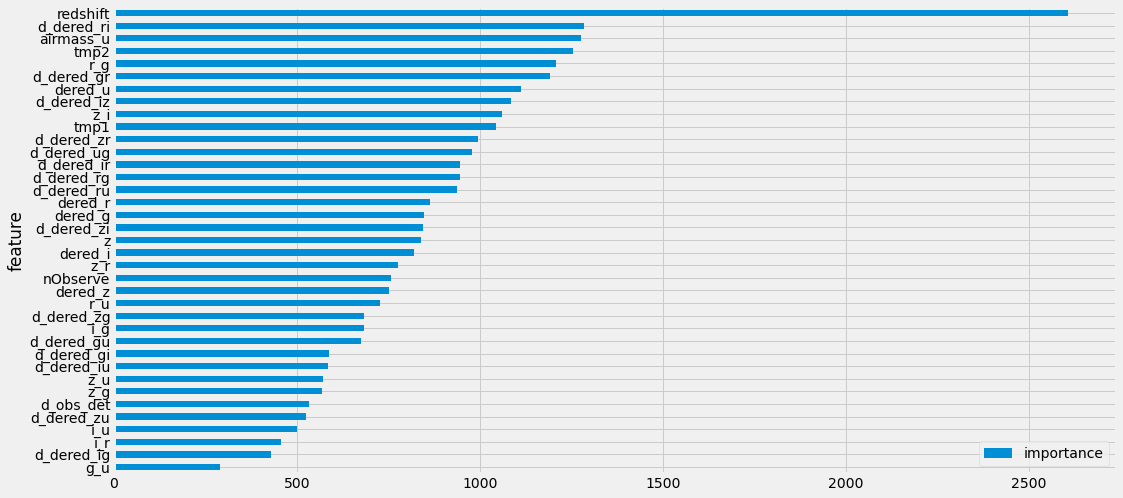

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    39503
0    29977
1    10520
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)